In [4]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Add 'src' to PYTHONPATH
sys.path.append(os.path.abspath('../src'))
from data_manipulation import add_feature, normalize_bmi

## Data Analysis

In [5]:
asthma_data = pd.read_csv("../data/clean_asthma_data.csv").drop("Unnamed: 0", axis = 1)

First lets check if there are meaningful correlations between the different features and see if there is something interesting in the data distributions.

In [6]:
asthma_data.describe()

,age,education_level,bmi,physical_activity,diet_quality,sleep_quality,pollution_exposure,pollen_exposure,dust_exposure,lung_function_fev1,lung_function_fvc
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,42.137960,1.307274,27.244877,5.051786,5.022867,7.019012,5.013030,5.114221,4.981864,2.548564,3.741270
std,21.606655,0.898242,7.201628,2.903574,2.909980,1.732475,2.935605,2.893088,2.859192,0.861809,1.303689
min,5.000000,0.000000,15.031803,0.001740,0.003031,4.001437,0.001022,0.000659,0.002434,1.000459,1.500045
25%,23.000000,1.000000,20.968313,2.578333,2.432043,5.498500,2.432559,2.599996,2.467489,1.824113,2.607489
50%,42.000000,1.000000,27.052202,5.016881,5.115383,6.975839,5.036519,5.098452,4.903278,2.553244,3.734982
75%,61.000000,2.000000,33.555903,7.540234,7.544216,8.526950,7.630037,7.708836,7.432218,3.292897,4.864121
max,79.000000,3.000000,39.985611,9.995809,9.999904,9.996235,9.998964,9.999555,9.999708,3.999719,5.999421


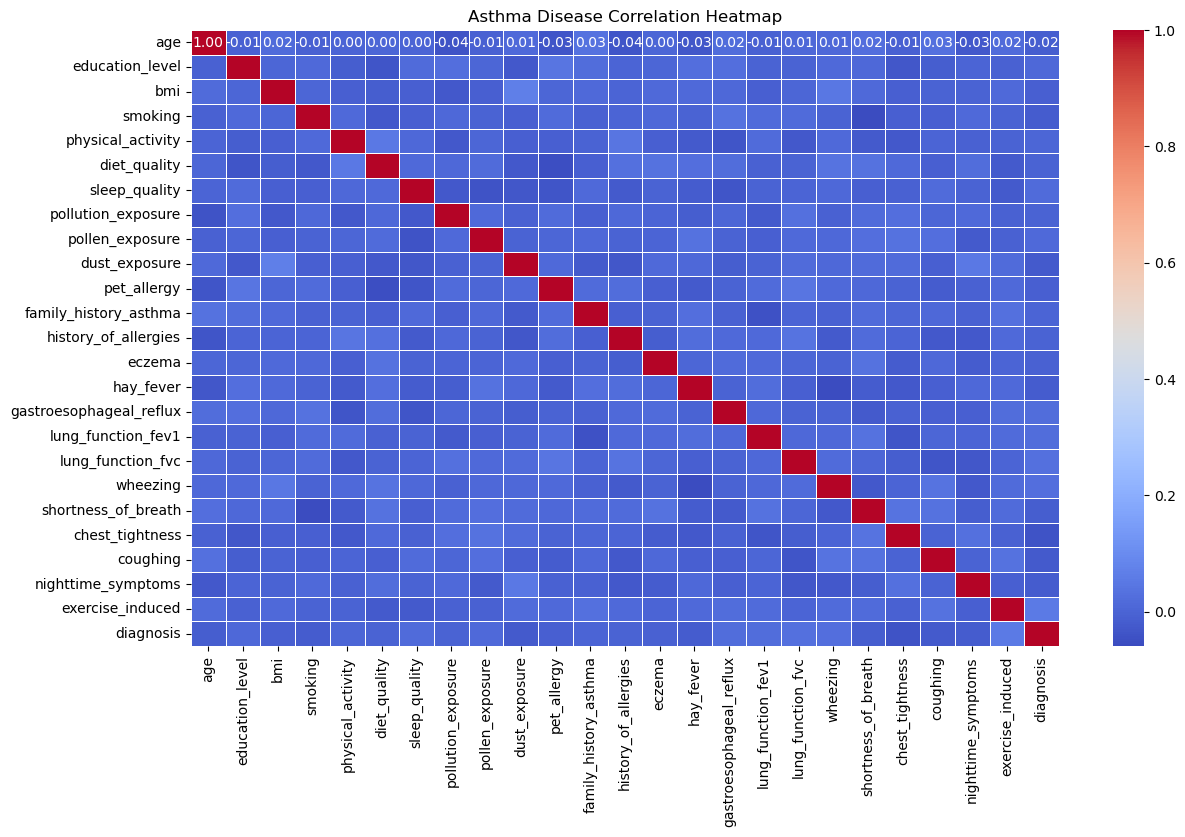

In [7]:
correlation_matrix = asthma_data.drop(['ethnicity', 'gender'], axis = 1).corr()
plt.figure(figsize=(14, 8))  # Optional: Adjust the figure size for better visibility
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Asthma Disease Correlation Heatmap')
plt.show()

There isn't a strong correlation between individual features. Next lets take a look at the BMI distribution. The distribution seems pretty linear on first sight, however if we split the bmi into 3 groups - underweight, healthy weight and overweight/obese, the picture will most likely change.

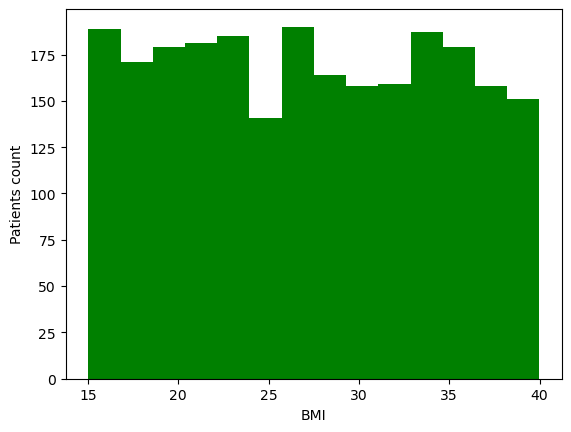

In [8]:
plt.hist(asthma_data.bmi, bins = 'fd', color = 'green')
plt.xlabel("BMI")
plt.ylabel("Patients count")

plt.show()

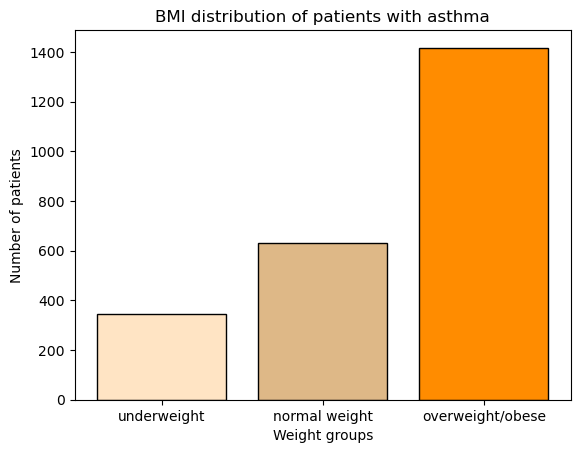

In [9]:
# Define the BMI categories in a new column based on the bmi ranges
asthma_data['bmi_category'] = pd.cut(asthma_data['bmi'],
                           bins=[0, 18.5, 24.9, float('inf')],
                           labels=['underweight', 'normal weight', 'overweight/obese'],
                           right=False)


bmi_counts = dict(asthma_data['bmi_category'].value_counts().sort_values()) #Crete a dictionary with the value counts

plt.bar(bmi_counts.keys(), bmi_counts.values(), color = ['bisque', 'burlywood', 'darkorange'], edgecolor = 'black')
plt.title("BMI distribution of patients with asthma")
plt.xlabel("Weight groups")
plt.ylabel("Number of patients")
plt.show()

Now we can clearly see that there are more overweight patients with asthma, than ones that aren't overweight. Lets check if there is something interesting with the number of patients of each ethnicity.

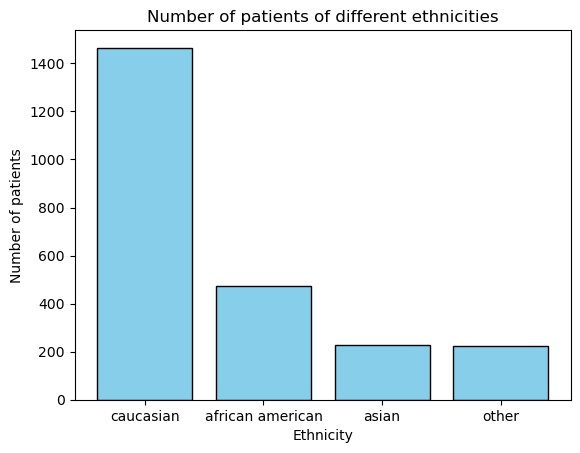

In [10]:
ethnicity_counts = asthma_data.ethnicity.value_counts()
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color = 'skyblue', edgecolor='black')
plt.xlabel('Ethnicity')
plt.ylabel('Number of patients')
plt.title('Number of patients of different ethnicities')
plt.show()

It looks like the patients are overwhelmingly of caucasian descent, but that is likely because of the region where the hospital is located, not because caucasian people are much more prone to the disease.

## Feature Engineering

First I will create a feature that shows the overall lifestyle quality of the patient, basing it on the lifestyle factor columns - BMI, smoking, sleep quality, diet quality, physical activity. I will create it by normalizing the columns and getting their mean as the new feature.

Standard normalization doesn't work for BMI, because both lower and higher values than the healthy range are considered bad. That's why I created the function **normalize_bmi**, which i will use

In [11]:
max_bmi = asthma_data.bmi.max()
min_bmi = asthma_data.bmi.min()
bmi_lower_bound = 18.5 #Below is considered unhealthy
bmi_upper_bound = 24.9 #Above is considered unhealthy
max_bmi, min_bmi

(39.985610652758176, 15.031803385194396)

In [12]:
#Create a dataset of only the columns that will be normalized
normalized_asthma_data = asthma_data[["bmi", "smoking", "sleep_quality", "diet_quality", "physical_activity"]].copy()

normalized_asthma_data.bmi = normalized_asthma_data.bmi.apply(lambda x: normalize_bmi(x, bmi_upper_bound, bmi_lower_bound, max_bmi, min_bmi))

In [13]:
#Use module sklearn.preprocessing
scaler = MinMaxScaler()

# Define columns to be normalized
columns_to_normalize = ['sleep_quality', 'diet_quality', 'physical_activity']

# Fit and transform the data using MinMaxScaler
normalized_asthma_data[columns_to_normalize] = scaler.fit_transform(normalized_asthma_data[columns_to_normalize])

#Invert the values of the smoking column, as 1 should be good and 0 should be bad
normalized_asthma_data.smoking = 1 - normalized_asthma_data.smoking

#Add the new feature to the original dataset
asthma_data["lifestyle_quality"] = normalized_asthma_data.mean(axis = 1)

In [14]:
normalized_asthma_data.mean()

bmi                  0.633602
smoking              0.858278
sleep_quality        0.503366
diet_quality         0.502141
physical_activity    0.505304
dtype: float64

This new feature is not perfect, because the different lifestyle factors probably all have different weights to them as some will have a bigger effect on predicting if a patient gets asthma or not. However the feature will still be useful to display that most patients that get the disease have a lower life quality.

In [15]:
asthma_data.lifestyle_quality.mean()

0.6005380421544235

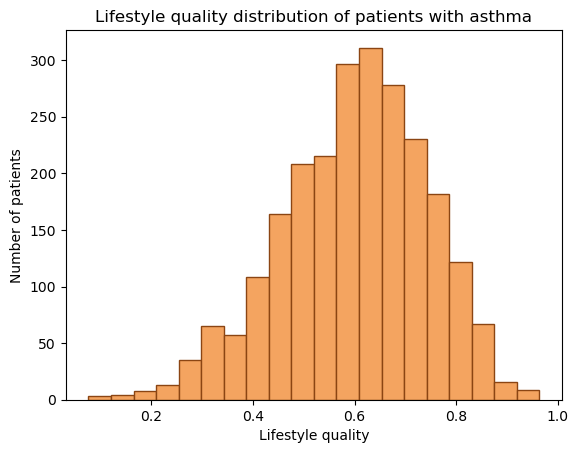

In [16]:
plt.hist(asthma_data.lifestyle_quality, bins = 20, color = 'sandybrown', edgecolor = 'saddlebrown')
plt.xlabel("Lifestyle quality")
plt.ylabel("Number of patients")
plt.title("Lifestyle quality distribution of patients with asthma")
plt.show()

To create other features I will use the **add_feature** function I created.

#### Feature for enviromental factors, showing the average exposure to negative factors

Based on:
* Pollution exposure
* Pollen exposure
* Dust exposure


I will exclude the pet allergies features, predicted to be in these factors, as I don't think it fits in the enviromental exposure factors.

In [17]:
new_feature = 'enviromental_exposure'
#All features get worse with increasing values
columns = ['pollution_exposure', 'pollen_exposure', 'dust_exposure']
asthma_data[new_feature] = add_feature(asthma_data, new_feature, positive_features = columns)

In [18]:
asthma_data[['enviromental_exposure']]

,enviromental_exposure
0,0.373879
1,0.533701
2,0.278414
3,0.403900
4,0.409665
...,...
2387,0.440733
2388,0.549342
2389,0.511113
2390,0.740430


For this new feature I made it so that higher value means more exposure, which is the opposite of what I did for the lifestyle quality feature.

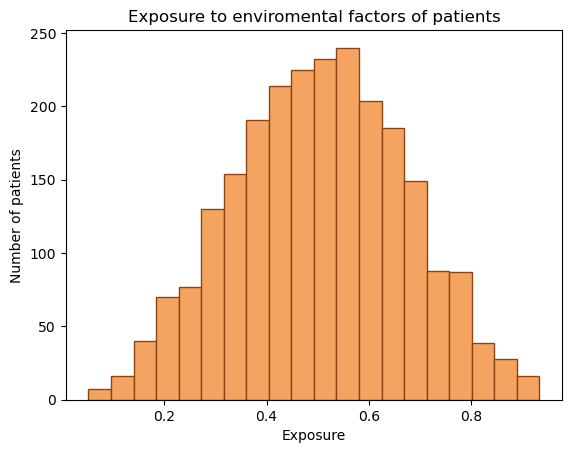

In [19]:
plt.hist(asthma_data.enviromental_exposure, bins = 20, color = 'sandybrown', edgecolor = 'saddlebrown')
plt.xlabel("Exposure")
plt.ylabel("Number of patients")
plt.title("Exposure to enviromental factors of patients")
plt.show()

#### Feature for medical history, showing the number of medical history factors that the patient has shows

Based on:
* Family history asthma
* History of allergies
* Eczema
* Hay fever
* Gastroesophageal reflux

In [20]:
medical_feature_name = 'medical_factors_count'
#All features are boolean values, so 1 = bad and 0 = good
medical_features = ['family_history_asthma', 'history_of_allergies', 'eczema', 'hay_fever', 'gastroesophageal_reflux']
asthma_data[medical_feature_name] = add_feature(asthma_data, medical_feature_name, positive_features = medical_features, total_count = True).astype('int')

In [21]:
asthma_data.medical_factors_count

0       1
1       1
2       3
3       1
4       1
       ..
2387    1
2388    1
2389    1
2390    3
2391    1
Name: medical_factors_count, Length: 2392, dtype: int32

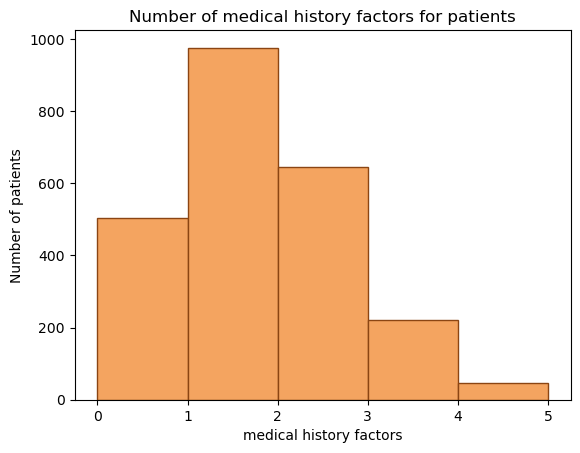

In [22]:
plt.hist(asthma_data.medical_factors_count, bins = len(medical_features), color = 'sandybrown', edgecolor = 'saddlebrown')
plt.xlabel("medical history factors")
plt.ylabel("Number of patients")
plt.title("Number of medical history factors for patients")
plt.show()

Only a few patients have more than 3 factors.

#### Feature for total number of shown symptoms by patients

Based on:
* Wheezing
* Shortness of breath
* Coughing
* Nighttime symptoms
* Exercise induced

This will be done in the exact same way as for the medical features

In [23]:
symptoms_feature_name = 'symptoms_count'
#All features are boolean values, so 1 = bad and 0 = good
symptom_features = ['wheezing', 'shortness_of_breath', 'chest_tightness', 'coughing', 'nighttime_symptoms', 'exercise_induced']
asthma_data[symptoms_feature_name] = add_feature(asthma_data, symptoms_feature_name, positive_features = symptom_features, total_count = True).astype('int')

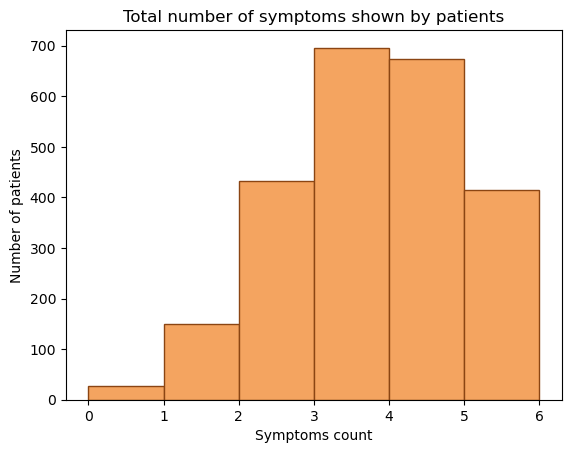

In [24]:
plt.hist(asthma_data.symptoms_count, bins = len(symptom_features), color = 'sandybrown', edgecolor = 'saddlebrown')
plt.xlabel("Symptoms count")
plt.ylabel("Number of patients")
plt.title("Total number of symptoms shown by patients")
plt.show()

Most patients show more than two of the symptoms.